## Imports

In [2]:
import sys
sys.path.append('../')
from parameters import D1_ND, Parameters
from twobox import TwoBox
import numpy as np
import matplotlib.pyplot as plt

## Build grating

In [118]:
grating_type = "Ilic"

if grating_type=="Ilic":
    ## Ilic
    wavelength      = 1.5 / D1_ND(5.3/100)
    grating_pitch   = 1.8 / wavelength
    grating_depth   = 0.5 / wavelength
    box1_width      = 0.15 * grating_pitch
    box2_width      = 0.35 * grating_pitch
    box_centre_dist = 0.60 * grating_pitch
    box1_eps        = 3.5**2 
    box2_eps        = 3.5**2
    gaussian_width  = 2 * 10
    substrate_depth = 0.5 / wavelength
    substrate_eps   = 1.45**2
if grating_type=="Optimised":
    ## Optimised - second
    grating_pitch   = 1.5384469388251338
    grating_depth   = 0.5580762361523982
    box1_width      = 0.10227122552871484
    box2_width      = 0.07605954942866577
    box_centre_dist = 0.2669020979549422
    box1_eps        = 9.614975107945112
    box2_eps        = 9.382304398409568
    gaussian_width  = 33.916288616522735
    substrate_depth = 0.17299998450776535
    substrate_eps   = 9.423032644325023
if grating_type=="First":
    grating_pitch       = 1.2269811605680625
    grating_depth       = 1.0708522822331097
    box1_width          = 0.14980809568967832
    box2_width          = 0.3138280436942734
    box_centre_dist     = 0.3563592721858686
    box1_eps            = 10.519396098839394
    box2_eps            = 2.1346426711459654
    gaussian_width      = 27.58894024158397
    substrate_depth     = 0.5382848081542992
    substrate_eps       = 9.270741779881561

wavelength      = 1.
angle           = 0.
Nx              = 100
numG            = 25
Qabs            = np.inf

grating = TwoBox(grating_pitch, grating_depth, box1_width, box2_width, box_centre_dist, box1_eps, box2_eps, 
                 gaussian_width, substrate_depth, substrate_eps,
                 wavelength, angle, Nx, numG, Qabs)

## Structure

In [ ]:
_, _, p_fig, p_ax = grating.show_permittivity(show_analytic_box=True)

## Gather data over wavelength (velocity) range

In [119]:
I = 10e9 #0.5 * 10**9
final_speed = 2.7
num_points = 200
wavelength_range = np.linspace(1, 1/D1_ND(final_speed/100), num_points)

####################
## Build arrays

## Q arrays
Q1 = np.zeros(num_points)
Q2 = np.zeros(num_points)

## Restoring arrays
kyy = np.zeros(num_points)
kyphi = np.zeros(num_points)
kphiy = np.zeros(num_points)
kphiphi = np.zeros(num_points)

## Damping arrays
muyy = np.zeros(num_points)
muyphi = np.zeros(num_points)
muphiy = np.zeros(num_points)
muphiphi = np.zeros(num_points)

## Eigenvalue arrays
real1 = np.zeros(num_points)
real2 = np.zeros(num_points)
real3 = np.zeros(num_points)
real4 = np.zeros(num_points)
imag1 = np.zeros(num_points)
imag2 = np.zeros(num_points)
imag3 = np.zeros(num_points)
imag4 = np.zeros(num_points)

## Calculate data
for i in range(num_points):
    wavelength = wavelength_range[i]
    Qs_array, rest_array, damp_array, real_array, imag_array = grating.Linear_info(wavelength, I)
    ## Save to arrays
    Q1[i] = Qs_array[0];        Q2[i] = Qs_array[1]
    kyy[i] = rest_array[0];     kyphi[i] = rest_array[1];       kphiy[i] = rest_array[2];       kphiphi[i] = rest_array[3]
    muyy[i] = damp_array[0];    muyphi[i] = damp_array[1];      muphiy[i] = damp_array[2];      muphiphi[i] = damp_array[3]
    real1[i] = real_array[0];   real2[i] = real_array[1];       real3[i] = real_array[2];       real4[i] = real_array[3]
    imag1[i] = imag_array[0];   imag2[i] = imag_array[1];       imag3[i] = imag_array[2];       imag4[i] = imag_array[3]

wavelength_minmax = [1, 1/D1_ND(final_speed/100)]

## Convert wavelength to velocity
v = np.zeros(num_points)
for i in range(num_points):
    D = 1/wavelength_range[i]
    v[i] = (1-D**2)/(1+D**2)
v = v*100
vlim = [0,final_speed]


In [121]:
m=1/1000            # mass (1g)
c=299792458
real,imag,P = grating.Eigs(I,m,c,grad_method="grad",check_det=False,return_vec=True)
print(real[0],real[1])
print(np.imag(P[:,0]))
print(np.imag(P[:,1]))
# print(np.imag(P[:,2]))
# print(np.imag(P[:,3]))
print(np.real(P[:,0]))
print(np.real(P[:,1]))
# print(np.real(P[:,2]))
# print(np.real(P[:,3]))

-0.0041311979426626524 -0.0041311979426626524
[ 3.69457284e-03  2.25254613e-03  0.00000000e+00 -1.04299464e-05]
[-3.69457284e-03 -2.25254613e-03 -0.00000000e+00  1.04299464e-05]
[ 6.60452635e-08 -4.86471688e-09 -8.53813059e-01 -5.20561751e-01]
[ 6.60452635e-08 -4.86471688e-09 -8.53813059e-01 -5.20561751e-01]


## Plot eigenvalues

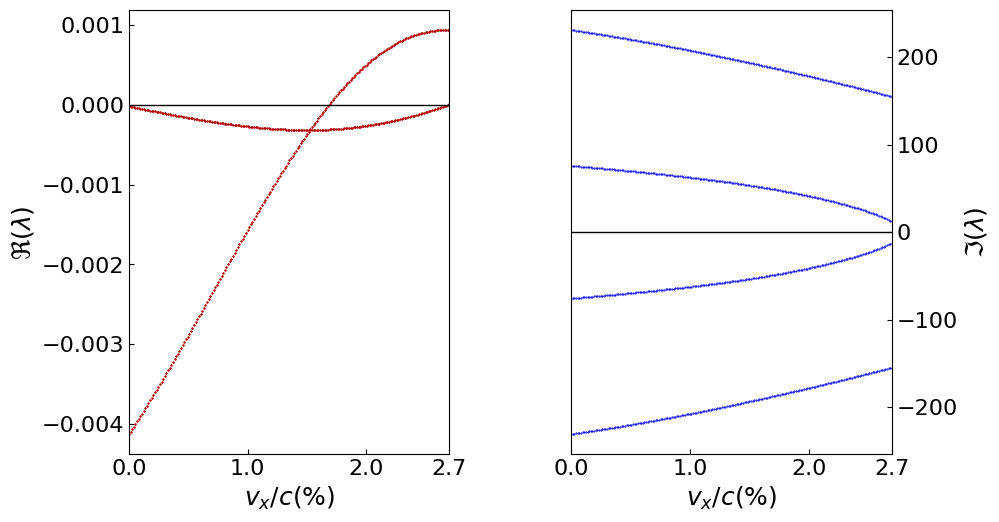

In [127]:
### PLOTTING ### 

# Set up figure
fig, (ax1, dummy, ax2) = plt.subplots(nrows=1, ncols=3, width_ratios=(1,0.1,1))
# fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
dummy.axis('off')
# p = grating.grating_pitch
# ax1.set_xlim(np.array(wavelength_minmax)/p)
# ax2.set_xlim(np.array(wavelength_minmax)/p) 
ax1.set_xlim(vlim)
ax1.set_xticks([0,1,2,2.7])
ax2.set_xlim(vlim) 
ax2.set_xticks([0,1,2,2.7])
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

## Plot eigs vs wavelength ##
colorReal=(0.7, 0, 0)
ax1.plot(v,real1, 'o', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real2, 'o', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real3, 'o', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ax1.plot(v,real4, 'o', markersize=0.5, markerfacecolor=colorReal, fillstyle='full',  color=colorReal)
ylabel=rf"$\Re(\lambda)$"

colorImag= 'blue'
ax2.plot(v,imag1, 'o', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag2, 'o', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag3, 'o', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ax2.plot(v,imag4, 'o', markersize=0.5, markerfacecolor=colorImag, fillstyle='full',  color=colorImag)
ylabel2=rf"$\Im(\lambda)$"

# ## Logarithmic
# if log_1:
#     linthr = 0.1
#     ax1.set_yscale("symlog", linthresh=linthr, linscale=0.4)
#     ax1.yaxis.set_minor_locator(MinorSymLogLocator(linthr))
# if log_2:
#     linthr = 0.1
#     ax2.set_yscale("symlog", linthresh=linthr, linscale=0.4)
#     ax2.yaxis.set_minor_locator(MinorSymLogLocator(linthr))


# Axis labels
ax1.axhline(y=0, color='black', linestyle='-', lw = '1')
ax1.tick_params(axis='both', which='both', direction='in') # ticks inside box
# ax1.tick_params(axis='y', color=colorReal, labelcolor=colorReal) # colored ticks
ax1.set_ylabel(ylabel=ylabel)  #color=colorReal  # colored y label
# ax1.set(xlabel=r"$\lambda'/\Lambda'$")
ax1.set(xlabel=r"$v_x/c (\%)$")

ax2.axhline(y=0, color='black', linestyle='-', lw = '1')
ax2.tick_params(axis='both', which='both', direction='in') # ticks inside box
# ax2.tick_params(axis='y', color = colorImag, labelcolor=colorImag) # colored ticks
ax2.set_ylabel(ylabel=ylabel2) #color=colorImag  # colored y label
# ax2.set(xlabel=r"$\lambda'/\Lambda'$")
ax2.set(xlabel=r"$v_x/c (\%)$")

# fig.suptitle(t=rf"$h_1' = {self.grating_depth/self.wavelength:.3f}\lambda_0$, $\Lambda' = {self.grating_pitch/self.wavelength:.3f}\lambda_0$")

# Modify axes
cm_to_inch = 0.393701
fig_width = 30*cm_to_inch
fig_height = 17.6*cm_to_inch
fig.set_size_inches(fig_width/1.2, fig_height/1.2)

## Plot restoring terms

In [123]:
## Colors

colorX="black"   
colorvX="xkcd:pine green"

colorY="blue"
colorvY="dodgerblue"  #cornflowerblue

colorphi="red"  #"royalblue"
colorvphi="tomato"  #coral

colorRotate="darkgreen"
colorRotateRate="seagreen"

LabelSize=15

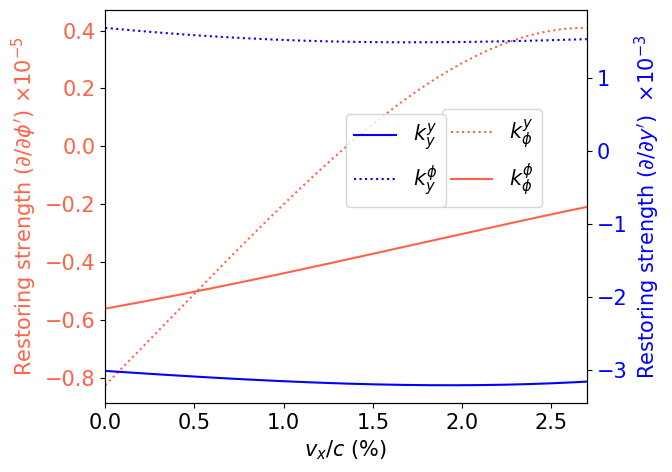

In [124]:
################
# Restoring terms

fig,ax=plt.subplots(1,1,figsize=(7,5))

ax.plot(v,kyphi*1e-5,  label="$k^y_\phi$",color=colorvphi,linestyle="dotted")
ax.plot(v,kphiphi*1e-5,label="$k^\phi_\phi$",color=colorvphi)

ax.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax.set_ylabel("Restoring strength ($\partial/\partial \phi'$) $\\times 10^{-5}$",fontsize=LabelSize,color=colorvphi)
ax.tick_params(labelsize=15)
ax.tick_params(axis='y',labelcolor=colorvphi)


# ax.hlines(0,0,5,"k","dashed",alpha=0.2)
t=ax.get_ylim()
# ax.axhspan(0,t[1],color='black',alpha=0.2)

ax1=ax.twinx()

ax1.plot(v,kphiy*1e-3,  label="$k^\phi_y$",color=colorY,linestyle="dotted")
ax1.plot(v,kyy*1e-3,    label="$k^y_y$",color=colorY)

ax1.set_ylabel("Restoring strength ($\partial/\partial y'$)  $\\times 10^{-3}$",fontsize=LabelSize,color=colorY)
ax1.tick_params(labelsize=15)
ax1.tick_params(axis='y',labelcolor=colorY)


ax.set_ylim(t)
ax.set_xlim(vlim)

# ax.set_xticks([0,1,1.45,2,3,4,5])

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.5+0.2,0.5),fontsize=LabelSize)
ax1.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.5,0.5),fontsize=LabelSize)

fig.tight_layout()
# plt.savefig("Saved/Restoring300.jpeg",format="jpeg",dpi=300,bbox_inches='tight')
# plt.close()



## Damping terms

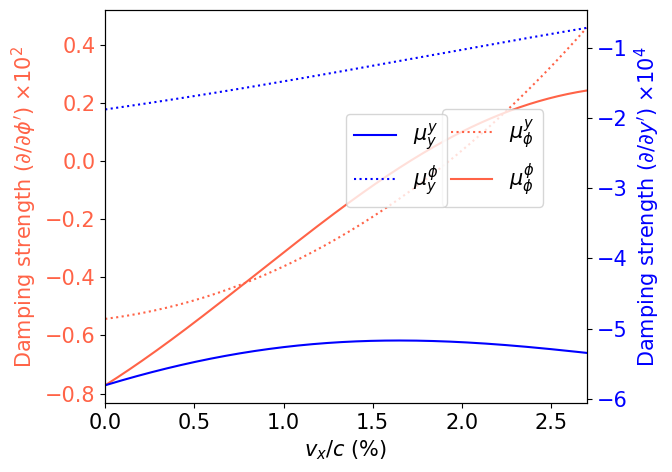

In [125]:
##############
# Damping terms

fig,ax=plt.subplots(1,1,figsize=(7,5))


ax.plot(v,muyphi*1e2,  label="$\mu^y_\phi$",color=colorvphi,linestyle="dotted")
ax.plot(v,muphiphi*1e2,label="$\mu^\phi_\phi$",color=colorvphi)

ax.set_xlabel("$v_x/c$ ($\%$)",fontsize=LabelSize)
ax.set_ylabel("Damping strength ($\partial/\partial \phi'$) $\\times 10^{2}$",fontsize=LabelSize,color=colorvphi)
ax.tick_params(labelsize=15)
ax.tick_params(axis='y',labelcolor=colorvphi)

t=ax.get_ylim()
ax1=ax.twinx()

ax1.plot(v,muphiy*1e4,  label="$\mu^\phi_y$",color=colorY,linestyle="dotted")
ax1.plot(v,muyy*1e4,    label="$\mu^y_y$",color=colorY)

ax1.set_ylabel("Damping strength ($\partial/\partial y'$) $\\times 10^{4}$",fontsize=LabelSize,color=colorY)
ax1.tick_params(labelsize=15)
ax1.tick_params(axis='y',labelcolor=colorY)

# # Does not correspond to 1.28%
# ax.vlines(1.4507253626813408,t[0],0,color='k',linestyle='dashed',alpha=0.2)
# ax.hlines(0,0,1.4507253626813408,color='k',linestyle='dashed',alpha=0.2)

ax.set_ylim(t)
ax.set_xlim(vlim)

# ax.set_xticks([0,1,1.45,2,3,4,5])

handles, labels = ax.get_legend_handles_labels()
handles1, labels1 = ax1.get_legend_handles_labels()
order = [0,1]
order1=[1,0]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0.5+0.2,0.5),fontsize=LabelSize)
ax1.legend([handles1[idx] for idx in order1],[labels1[idx] for idx in order1],loc=(0.5,0.5),fontsize=LabelSize)

fig.tight_layout()
# plt.savefig("Saved/Damping300.jpeg",format="jpeg",dpi=300,bbox_inches='tight')
# plt.close()


## Diffraction efficiencies at delta'=0 over wavelength

Text(0.5, 0.98, "Efficiency factors at $\\delta'=0$")

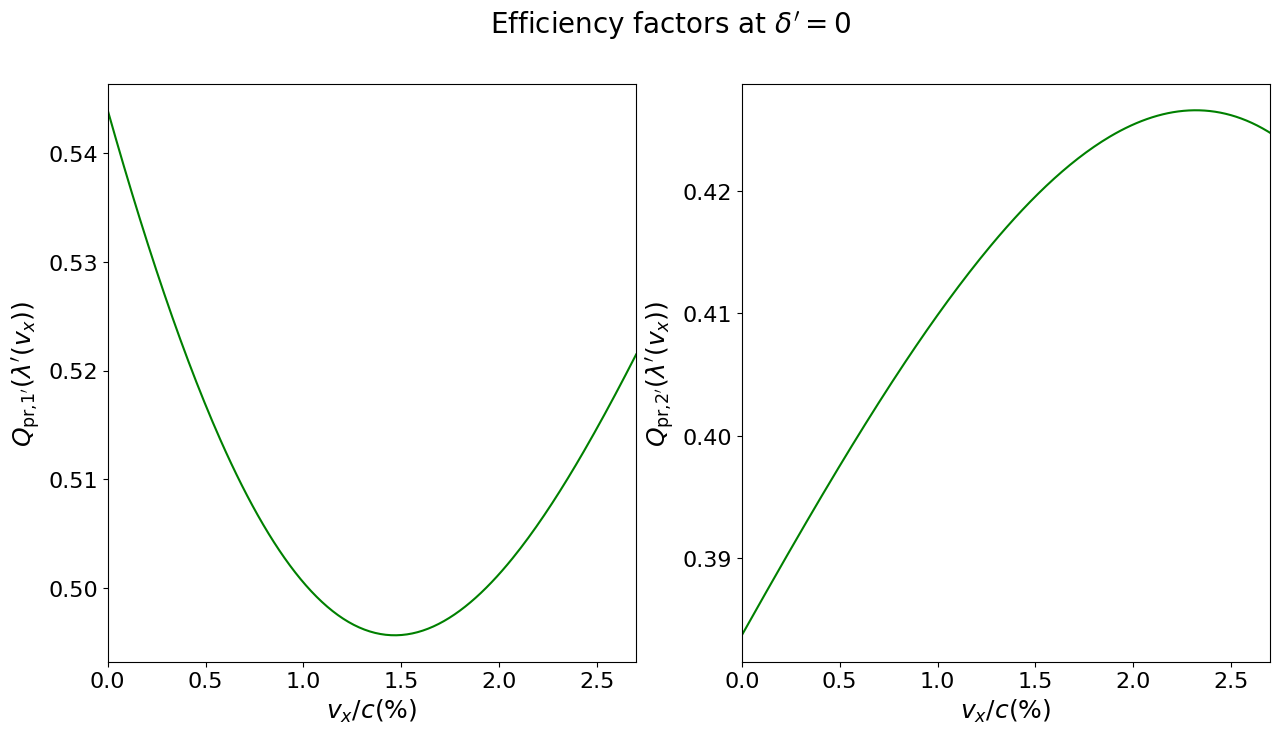

In [128]:
##############################
#### Plotting
cutoff = np.arcsin( 1 - wavelength / grating_pitch) * (180/np.pi)
cutoff2_test = 1 - 2* wavelength / grating_pitch
order_2 = False
if np.abs(cutoff2_test)<1:
    order_2 = True
    cutoff2 = np.arcsin(cutoff2_test) * (180/np.pi)

## Efficiency factors
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot(v, Q1,       color="green",    label="GRCWA")
ax2.plot(v, Q2,       color="green",    label="GRCWA")
ax1.set_xlim(vlim)
ax2.set_xlim(vlim)


ax1.set_xlabel("$v_x/c (\%)$")
ax1.set_ylabel("$Q_{\\text{pr,1}'} (\lambda'(v_x))$")
ax2.set_xlabel("$v_x/c (\%)$")
ax2.set_ylabel("$Q_{\\text{pr,2}'} (\lambda'(v_x))$")

fig.suptitle(rf"Efficiency factors at $\delta'=0$")

## Diffraction efficiencies over angle

Text(0.5, 0.98, "Efficiency factors at $\\lambda'=$ 1.00")

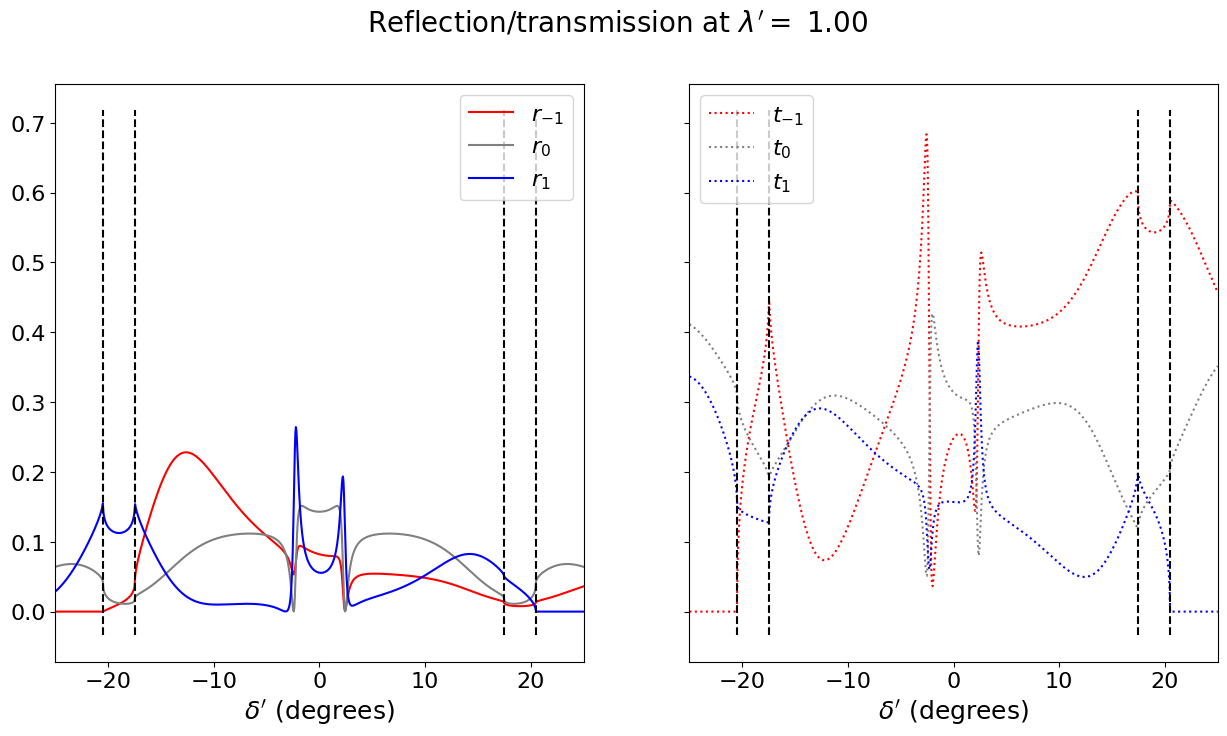

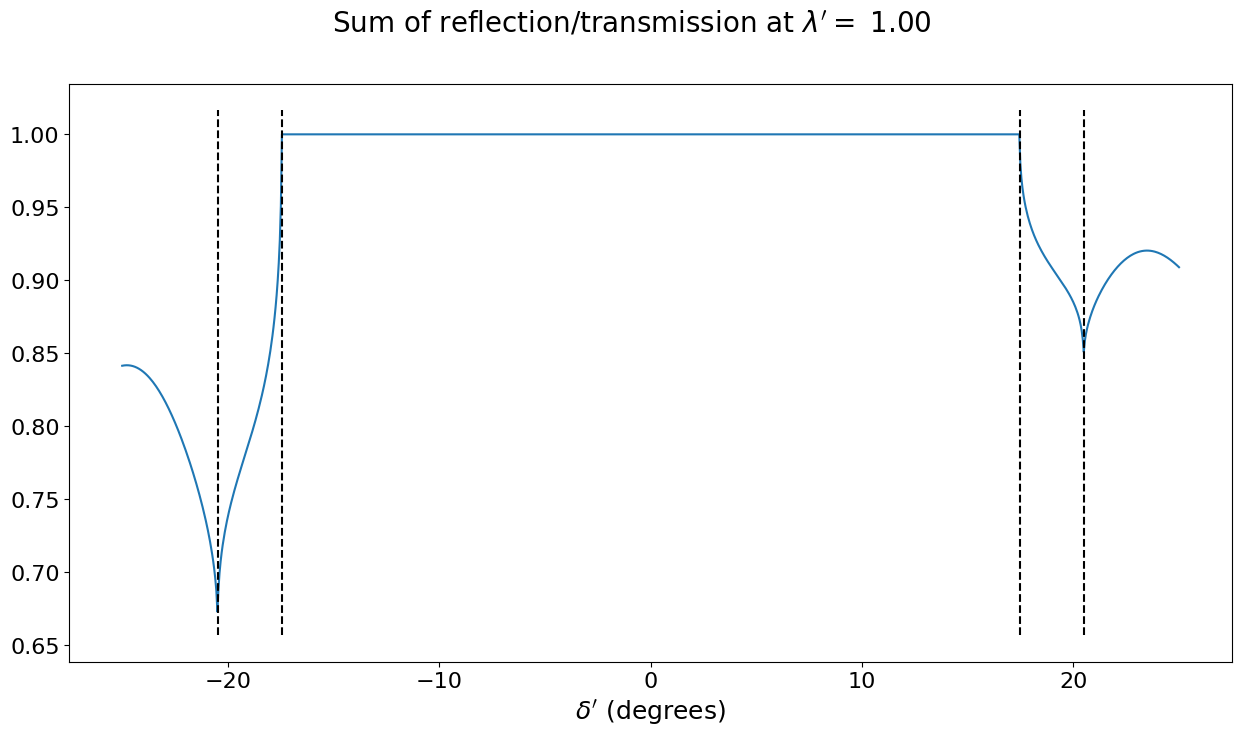

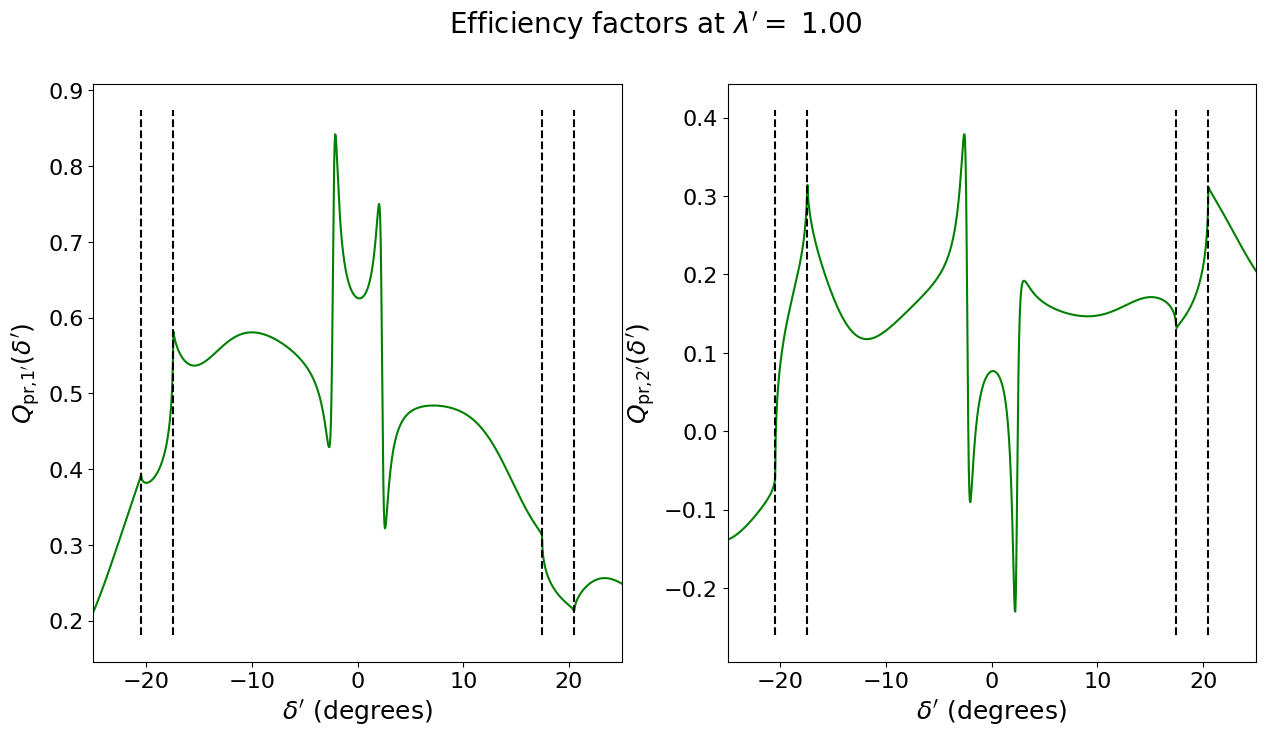

In [91]:
def Q(angle, r, t):
    def beta_m(m):
        test=(np.sin(angle)+m*wavelength/grating_pitch)
        if abs(test)>=1:
            delta_m="no_diffraction_order"
        else:
            delta_m=np.arcsin(test)
        return delta_m
    Q1=0
    Q2=0
    M=[-1,0,1]
    for m in range(len(M)):
        delta_m=beta_m(M[m])
        if isinstance(delta_m,str):
            Q1=Q1+0
            Q2=Q2+0
        else:
            Q1=Q1+ r[m]*(1+np.cos(angle+delta_m))+t[m]*(1-np.cos(delta_m-angle))
            Q2=Q2+ r[m]*np.sin(angle+delta_m)+t[m]*np.sin(delta_m-angle)
    Q1=np.cos(angle)*Q1
    Q2=-np.cos(angle)*Q2
    return Q1,Q2

import matplotlib.pyplot as plt
wavelength = 1. #1/D1_ND(4/100)
k = 1000
angles = (np.pi/180)*np.linspace(-25,25,k)

Q1_array = []
Q2_array = []

Rs = [] 
Ts = [] 

grating.wavelength = wavelength
for i in range(k):
    angle = angles[i]
    grating.angle = angle
    r, t = grating.eff()

    Rs.append(r)
    Ts.append(t)

    Q1, Q2 = Q(angle, r, t)
    Q1_array.append(Q1)
    Q2_array.append(Q2)

Q1_array = np.array(Q1_array)
Q2_array = np.array(Q2_array)
Rs = np.array(Rs)
Ts = np.array(Ts)

#### Plotting
cutoff = np.arcsin( 1 - wavelength / grating_pitch) * (180/np.pi)
cutoff2_test = 1 - 2* wavelength / grating_pitch
order_2 = False
if np.abs(cutoff2_test)<1:
    order_2 = True
    cutoff2 = np.arcsin(cutoff2_test) * (180/np.pi)


##############################
## Reflection/transmission
fig1, (ax, ax_) = plt.subplots(nrows=1, ncols=2, sharey=True)
ax.plot((180/np.pi)*angles, Rs[:,0], color="red",                       label="$r_{-1}$")
ax_.plot((180/np.pi)*angles, Ts[:,0], color="red", linestyle="dotted",  label="$t_{-1}$")
ax.plot((180/np.pi)*angles, Rs[:,1], color="grey",                      label="$r_{0}$")
ax_.plot((180/np.pi)*angles, Ts[:,1], color="grey", linestyle="dotted", label="$t_{0}$")
ax.plot((180/np.pi)*angles, Rs[:,2], color="blue",                      label="$r_{1}$")
ax_.plot((180/np.pi)*angles, Ts[:,2], color="blue", linestyle="dotted", label="$t_{1}$")

ax.legend()
ax_.legend()

ax_ylims = ax.get_ylim()
ax__ylims = ax_.get_ylim()
ax.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])
ax_.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])

ax.vlines(x= cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax.vlines(x=-cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax_.vlines(x= cutoff, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
ax_.vlines(x=-cutoff, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax.vlines(x= cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax.vlines(x=-cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax_.vlines(x= cutoff2, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')
    ax_.vlines(x=-cutoff2, ymin=ax__ylims[0], ymax=ax__ylims[1], color='black', linestyle = 'dashed')

ax.set_xlabel("$\delta'$ (degrees)")
ax_.set_xlabel("$\delta'$ (degrees)")
fig1.suptitle(rf"Reflection/transmission at $\lambda'=$ {wavelength:.2f}")

##############################
## Sum
fig, ax1 = plt.subplots(nrows=1, ncols=1)
ax1.plot((180/np.pi)*angles, Rs[:,0]+Rs[:,1]+Rs[:,2] + Ts[:,0]+Ts[:,1]+Ts[:,2])
ax_ylims = ax1.get_ylim()
ax1.vlines(x= cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax1.vlines(x=-cutoff, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax1.vlines(x= cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
    ax1.vlines(x=-cutoff2, ymin=ax_ylims[0], ymax=ax_ylims[1], color='black', linestyle = 'dashed')
ax1.set_xlabel("$\delta'$ (degrees)")
fig.suptitle(rf"Sum of reflection/transmission at $\lambda'=$ {wavelength:.2f}")

##############################
## Efficiency factors
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
ax1.plot((180/np.pi)*angles, Q1_array,       color="green",    label="GRCWA")
ax2.plot((180/np.pi)*angles, Q2_array,       color="green",    label="GRCWA")
ax1.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])
ax2.set_xlim(xmin=(180/np.pi)*angles[0], xmax=(180/np.pi)*angles[-1])

ax1_ylims = ax1.get_ylim()
ax2_ylims = ax2.get_ylim()

ax1.vlines(x= cutoff, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
ax1.vlines(x=-cutoff, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
ax2.vlines(x= cutoff, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
ax2.vlines(x=-cutoff, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
if order_2:
    ax1.vlines(x= cutoff2, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
    ax1.vlines(x=-cutoff2, ymin=ax1_ylims[0], ymax=ax1_ylims[1], color='black', linestyle = 'dashed')
    ax2.vlines(x= cutoff2, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')
    ax2.vlines(x=-cutoff2, ymin=ax2_ylims[0], ymax=ax2_ylims[1], color='black', linestyle = 'dashed')

ax1.set_xlabel("$\delta'$ (degrees)")
ax1.set_ylabel("$Q_{\\text{pr,1}'} (\delta')$")
ax2.set_xlabel("$\delta'$ (degrees)")
ax2.set_ylabel("$Q_{\\text{pr,2}'} (\delta')$")

fig.suptitle(rf"Efficiency factors at $\lambda'=$ {wavelength:.2f}")
